# Text Clasiffier with CNN

In [1]:
# Librerías
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D,  MaxPooling1D, Embedding
from tensorflow.keras.models import Model

In [2]:
# Cargando datos
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
# Eliminamos columnas que no nos interesan
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
# Cambiamos el nombre de las columnas
df.rename(columns={'v1':'labels', 'v2':'data'}, inplace=True)
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# Cambiando las etiquetas de 'labels' por: ham=0, spam=1
df['b_labels'] = df['labels'].map({'ham':0, 'spam':1})
df['data'] = df['data'].astype(str)
df.head()

,labels,data,b_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [4]:
# Creando nuestro vector de respuesta
y = df['b_labels'].values
y

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [5]:
# Separar en train y test (70 y 30)
X_train, X_test, y_train, y_test = train_test_split(df['data'], y, test_size=30)

In [6]:
# Vamos a entrenar un Tokenizer para obtener los tokens, limitando el tamaño del vocabulario a 20,000 palabras
max_vocab_size = 20000
tokenizer = Tokenizer(num_words=max_vocab_size)

# Entrenando el modelo
tokenizer.fit_on_texts(texts=X_train)

In [7]:
# Convertimos los textos a secuencias de enteros para la clasificación
sequence_train = tokenizer.texts_to_sequences(X_train)
sequence_test = tokenizer.texts_to_sequences(X_test)

In [8]:
# Cuántas y Cuáles son las palabras únicas en el corpus
word2idx = tokenizer.word_index
# Sacando cuántas palabras únicas hay en el corpus
V = len(word2idx)
V

8880

In [9]:
# Vamos a construit una matriz de características de NxT
# Donde N: es el número de muestras que vamos a tomar
# y T: son los 'time_steps' para tomar las muestras
data_train = pad_sequences(sequence_train)
data_train.shape

(5542, 189)

In [10]:
# Extraemos el valor de 'T' para tener la longitud de cada secuencia
T = data_train.shape[1]
T

189

In [11]:
# Hacemos el pad de las secuencias de test, limitado a la longitd para que sea la misma que la secuencia de entrenamiento.
data_test = pad_sequences(sequence_test, maxlen=T)
data_test.shape

(30, 189)

## Construcción del Modelo

In [12]:
# Vamos a construit nuestro modelo paso a paso (capa x capa)
D = 20 # Hiperparámetro que determina el tamaño del vector (podemos seleccionar el que sea)

# Input Layer
i = Input(shape=(T,)) # La capa de entrada toma secuencias de enteros con tamaño 'T'

# Embedding Layer
x = Embedding(V + 1, D)(i) # Toma secuencias de enteros y regresa secuencias de vectores de palabras
# La forma de este nuevo vector será N * T * D
# V + 1, es porque la primera palabra del 'word2index' está en 1, no en 0.

# Primera CNN layer
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)

# Segunda CNN layer
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)

# Tercera CNN layer
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

# La capa 'Dense' (ANN totalmente conectada)
x = Dense(1, activation='sigmoid')(x)

# Finalmente todo para formar nuestro modelo
model = Model(i, x)

In [17]:
# Compilamos el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [18]:
# Entrenamiento del Modelo
r = model.fit(x=data_train,
              y=y_train,
              epochs=5,
              validation_data=(data_test, y_test))

Epoch 1/5
174/174 [==============================] - 3s 11ms/step - loss: 0.3320 - accuracy: 0.8780 - val_loss: 0.1676 - val_accuracy: 0.9333
Epoch 2/5
174/174 [==============================] - 2s 10ms/step - loss: 0.0551 - accuracy: 0.9838 - val_loss: 0.0153 - val_accuracy: 1.0000
Epoch 3/5
174/174 [==============================] - 2s 9ms/step - loss: 0.0116 - accuracy: 0.9969 - val_loss: 0.0053 - val_accuracy: 1.0000
Epoch 4/5
174/174 [==============================] - 2s 9ms/step - loss: 0.0034 - accuracy: 0.9995 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 5/5
174/174 [==============================] - 2s 10ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0016 - val_accuracy: 1.0000


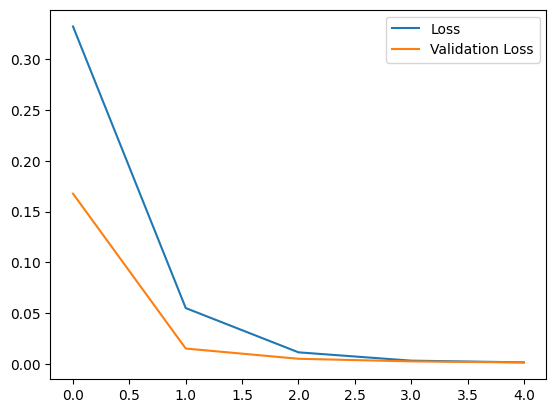

In [23]:
# Loss por iteración
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

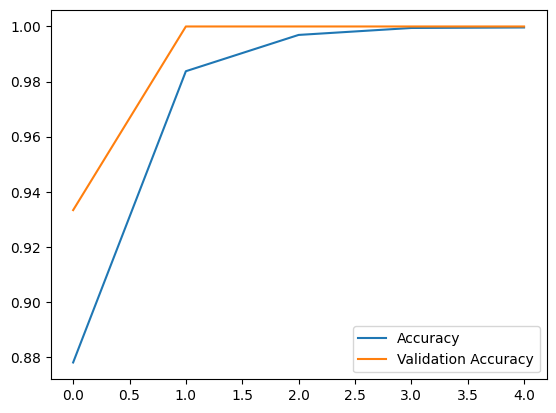

In [24]:
# Accuracy por iteración
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()